In [2]:
import sys
sys.version

'3.8.2 (default, Aug 25 2020, 09:23:57) \n[Clang 12.0.0 (clang-1200.0.32.2)]'

In [53]:
from matplotlib import pyplot as plt
import pandas as pd

pd.set_option('max_columns', 0)

In [7]:
df = pd.read_csv('covid_19/COVID19_Fallzahlen_CH_total_v2.csv')
print(len(df))
df.tail()

4926


,date,time,abbreviation_canton_and_fl,ncumul_tested,ncumul_conf,new_hosp,current_hosp,current_icu,current_vent,ncumul_released,ncumul_deceased,source,current_isolated,current_quarantined,current_quarantined_riskareatravel,current_quarantined_total
4921,2020-09-22,10:15,SH,NaN,185.0,NaN,0.0,0.0,NaN,NaN,8.0,https://sh.ch/CMS/get/file/94f4a1b1-bf31-4809-...,7.0,54.0,NaN,NaN
4922,2020-09-22,11:00,GL,NaN,174.0,NaN,0.0,NaN,NaN,NaN,13.0,https://www.gl.ch/public/upload/assets/30317/C...,NaN,NaN,NaN,NaN
4923,2020-09-22,12:00,AI,NaN,33.0,NaN,NaN,NaN,NaN,NaN,0.0,https://www.ai.ch/themen/gesundheit-alter-und-...,4.0,42.0,NaN,NaN
4924,2020-09-22,14:30,ZH,NaN,7488.0,NaN,26.0,NaN,6.0,NaN,NaN,https://www.zh.ch/de/gesundheit/coronavirus.html,477.0,999.0,NaN,NaN
4925,2020-09-22,16:00,UR,NaN,141.0,NaN,0.0,NaN,NaN,132.0,7.0,https://www.ur.ch/themen/2962,NaN,28.0,NaN,NaN


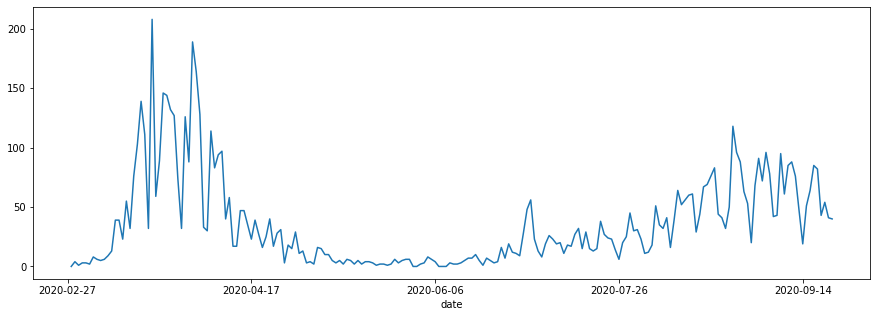

In [12]:
# new ZH cases
plt.figure(figsize=(15, 5))
df[df.abbreviation_canton_and_fl == 'ZH'].set_index('date').ncumul_conf.diff().plot();

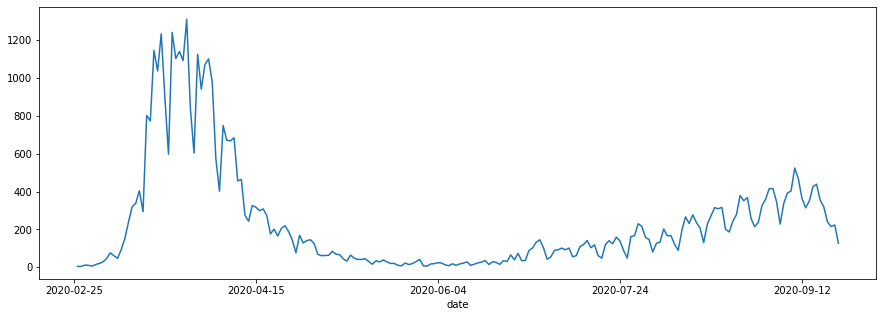

In [67]:
# new CH cases (filled)
plt.figure(figsize=(15, 5))
df.set_index(['date', 'abbreviation_canton_and_fl']).ncumul_conf.unstack().fillna(method='ffill').stack().reset_index().rename(columns={0: 'ncumul_conf'}).groupby('date').ncumul_conf.sum().diff().plot();

In [52]:
# latest new cases by canton (filled)
df.set_index(['date', 'abbreviation_canton_and_fl']).ncumul_conf.unstack().fillna(method='ffill').diff().tail(10).astype(int)

abbreviation_canton_and_fl,AG,AI,AR,BE,BL,BS,FL,FR,GE,GL,GR,JU,LU,NE,NW,OW,SG,SH,SO,SZ,TG,TI,UR,VD,VS,ZG,ZH
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-09-13,13,0,0,42,0,7,0,33,25,0,0,0,0,4,0,0,31,0,0,0,4,0,0,101,7,0,47
2020-09-14,7,1,12,14,0,2,0,19,50,0,3,0,9,8,0,0,12,0,11,8,1,13,1,128,19,12,19
2020-09-15,28,0,0,27,8,4,0,26,60,0,1,2,11,6,0,0,20,0,4,1,3,0,0,159,10,4,51
2020-09-16,36,1,0,54,2,1,0,28,72,1,2,1,7,7,0,1,20,1,17,5,19,6,0,71,22,1,64
2020-09-17,22,3,6,43,5,3,1,18,58,1,1,2,12,6,1,1,33,3,7,3,9,8,0,0,22,1,85
2020-09-18,28,0,1,51,1,7,0,26,62,2,3,3,10,6,0,0,0,1,9,0,6,4,0,0,12,4,82
2020-09-19,12,0,0,60,3,2,1,37,49,0,5,2,0,9,0,0,0,0,0,0,11,0,0,0,5,0,43
2020-09-20,14,0,0,50,0,2,0,16,24,0,0,1,0,4,1,0,42,0,0,0,1,0,0,0,6,0,54
2020-09-21,10,2,3,28,2,0,1,7,39,0,1,0,20,0,0,4,17,3,18,7,0,10,1,0,7,2,41


In [13]:
df[df.date == df.date.max()]

,date,time,abbreviation_canton_and_fl,ncumul_tested,ncumul_conf,new_hosp,current_hosp,current_icu,current_vent,ncumul_released,ncumul_deceased,source,current_isolated,current_quarantined,current_quarantined_riskareatravel,current_quarantined_total
4904,2020-09-22,NaN,BL,NaN,1123.0,NaN,3.0,0.0,0.0,1055.0,37.0,https://www.baselland.ch/politik-und-behorden/...,30.0,125.0,NaN,NaN
4905,2020-09-22,NaN,FL,NaN,115.0,NaN,NaN,NaN,NaN,NaN,1.0,https://www.regierung.li/media/attachments/497...,NaN,NaN,NaN,NaN
4906,2020-09-22,NaN,FR,NaN,2313.0,NaN,9.0,3.0,NaN,171.0,101.0,https://www.fr.ch/sites/default/files/2020-09/...,NaN,NaN,NaN,NaN
4907,2020-09-22,NaN,GE,NaN,NaN,NaN,33.0,1.0,NaN,NaN,NaN,https://www.ge.ch/document/21502/telecharger,NaN,NaN,NaN,NaN
4908,2020-09-22,NaN,GR,NaN,1067.0,NaN,3.0,0.0,0.0,NaN,50.0,https://services1.arcgis.com/YAuo6vcW85VPu7OE/...,18.0,64.0,NaN,NaN
4909,2020-09-22,NaN,LU,NaN,1188.0,NaN,7.0,0.0,NaN,NaN,23.0,https://gesundheit.lu.ch/themen/Humanmedizin/I...,66.0,129.0,NaN,NaN
4910,2020-09-22,NaN,NW,NaN,142.0,NaN,1.0,1.0,NaN,NaN,3.0,http://www.nw.ch/coronastatistik,NaN,NaN,NaN,NaN
4911,2020-09-22,NaN,SG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://stada.sg.ch/covid/ContactTracing.html,NaN,664.0,NaN,NaN
4912,2020-09-22,NaN,VS,NaN,2608.0,0.0,10.0,0.0,0.0,322.0,155.0,https://www.vs.ch/de/web/coronavirus,98.0,356.0,NaN,NaN
4913,2020-09-22,00:00,OW,NaN,116.0,NaN,0.0,NaN,NaN,NaN,0.0,https://www.ow.ch/dl.php/de/5f69f8b494864/OW-1...,NaN,NaN,NaN,NaN
